In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk

from sklearn.linear_model import LogisticRegression

%matplotlib inline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score, classification_report

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from textblob import TextBlob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

import pickle

__Dataset 1__ - __Emotion Stimulus__  - http://www.site.uottawa.ca/∼diana/resources/emotion_stimulus_data

In [3]:
dataset1_cause = pd.read_csv('Datasets/NLP/Dataset/Emotion Cause.txt', delimiter = "\t", header=None)
dataset1_nocause  = pd.read_csv('Datasets/NLP/Dataset/No Cause.txt',  delimiter = "\t", header=None)

In [4]:
dataset1_nocause = dataset1_nocause[0].str.split('>',  n = 1,expand=True) # Spliting on >
dataset1_cause = dataset1_cause[0].str.split('>',  n = 1,expand=True) # Splitting on >
dataset1_cause[0] = dataset1_cause[0].str[1:] # Removing < (first letter) from the first column
dataset1_nocause[0] = dataset1_nocause[0].str[1:] # Removing < (first letter) from the first column
dataset1_nocause[1] = dataset1_nocause[1].str.split('<' , expand = True)[0] #Spliting on '<' on text column and only keeping the text column 
# Removing <cause> labels from the sentences
dataset1_cause[1] = dataset1_cause[1].str.replace("<cause>" , "").str.replace("<\\\\cause>" , "").str.split('<' , expand = True)[0]
dataset1 = dataset1_cause.append(dataset1_nocause)
dataset1.columns = ['emotion', 'text'] #Renaming labels
dataset1

C:\Users\Isfan\anaconda3\envs\Capstone-NLP\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,emotion,text
0,happy,I suppose I am happy being so ` tiny' ; it mea...
1,happy,Lennox has always truly wanted to fight for th...
2,happy,"He was a professional musician now , still sen..."
3,happy,Holmes is happy having the freedom of the hous...
4,happy,I had problems with tutors trying to encourage...
...,...,...
1589,shame,He gets real humiliated and has to leave .
1590,shame,They aimed for higher status jobs and felt hum...
1591,shame,He cursed his lack of self-control ; he knew t...
1592,shame,Sometimes I've thought I 'll never forget wha...


In [5]:
dataset1['emotion'].value_counts()

sad         575
anger       483
happy       479
fear        423
surprise    213
shame       146
disgust      95
Name: emotion, dtype: int64

__Dataset 2__ - __DailyDialog__  - https://aclanthology.org/I17-1099/

In [6]:
dataset2_text = pd.read_csv('Datasets/NLP/EMNLP_dataset/dialogues_text.txt', delimiter = "\t", header=None)
dataset2_emo = pd.read_csv('Datasets/NLP/EMNLP_dataset/dialogues_emotion.txt', delimiter = "\t", header=None)

__Initial inspection__:
+ Sentences dataset has rows with multiple sentences
+ Emotion data has rows with multiple emotion
+ Emotion is labeled by `__eou__` in text data

In [7]:
d1 = pd.melt(dataset2_text[0].str.split('__eou__' , expand = True)) 
d2 = pd.melt(dataset2_emo[0].str.split(' ' , expand = True))
d = pd.DataFrame({"emotion": d2['value'], "text" : d1['value']})

In [8]:
dict = {
    '0': "no emotion", 
    '1': "anger",
    '2': "disgust",
    '3': "fear", 
    '4': "happy", 
    '5': "sad", 
    '6': "surprise"
}
# dictionary for emotions
d['emotion'] = d["emotion"].map(dict) # changing from 0-6 to emotions names by mapping the dictionary

In [9]:
noemotion_rows = d.loc[d['emotion'] == 'no emotion'].index #get index of all no emotion rows

In [10]:
d = d.drop(noemotion_rows, axis=0) #dropping the no emotion rows by index
d = d.dropna() #dropping the NA values
dataset2 = d
d

,emotion,text
0,disgust,The kitchen stinks .
1,happy,"So Dick , how about getting some coffee for to..."
5,happy,Isn ’ t he the best instructor ? I think he ’ ...
53,sad,I'm sorry I'm late .
69,happy,"I passed all the tests , Mom ."
...,...,...
384216,happy,That ’ s right . I have a lot to learn from y...
392619,happy,Excellent . I would be happy to get started o...
397334,happy,You can ask me any question at any time .
422879,happy,Thanks . My name's Nick .


In [11]:
dataset2['emotion'].value_counts() #Checking for distribtion of data

happy       12885
surprise     1823
sad          1150
anger        1022
disgust       353
fear          174
Name: emotion, dtype: int64

__Dataset 3__ - __Emotions dataset for NLP (Kaggle)__  - https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

In [12]:
dataset3_text_train = pd.read_csv('Datasets/NLP/Kaggle/train.txt', delimiter = "\t", header=None)
dataset3_text_test = pd.read_csv('Datasets/NLP/Kaggle/test.txt', delimiter = "\t", header=None)
dataset3_text_val = pd.read_csv('Datasets/NLP/Kaggle/val.txt', delimiter = "\t", header=None)
dataset3_text = dataset3_text_train.append([dataset3_text_test,dataset3_text_val]) #joining them by using command append

In [13]:
dataset3_text = dataset3_text[0].str.split(';',  n = 1,expand=True) #spliting on ;
dataset3_text[1].value_counts() #checking distribution of data
# Creating a dictionary to map

dict2 = {
    'joy': 'happy',
    'love': "love", 
    'anger': "anger",
    'fear': "fear", 
    'sadness': "sad", 
    'surprise': "surprise"
}
dataset3_text[1] = dataset3_text[1].map(dict2) #mapping
dataset3_text.columns = ['text', 'emotion']
dataset3 = dataset3_text
dataset3

,text,emotion
0,i didnt feel humiliated,sad
1,i can go from feeling so hopeless to so damned...,sad
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sad
1996,i constantly worry about their fight against n...,happy
1997,i feel its important to share this info for th...,happy
1998,i truly feel that if you are passionate enough...,happy


In [14]:
dataset3['emotion'].value_counts() #Checking

happy       6761
sad         5797
anger       2709
fear        2373
love        1641
surprise     719
Name: emotion, dtype: int64

---

In [15]:
dataset = dataset1.append(dataset2.append(dataset3))

In [16]:
dataset['emotion'].value_counts()

happy       20125
sad          7522
anger        4214
fear         2970
surprise     2755
love         1641
disgust       448
shame         146
Name: emotion, dtype: int64

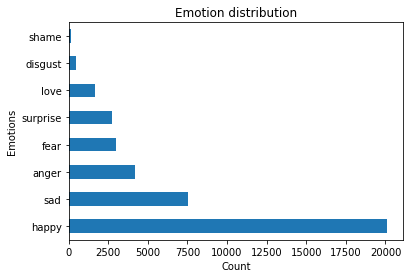

In [17]:
dataset['emotion'].value_counts().plot(kind = 'barh')
plt.title("Emotion distribution")
plt.xlabel("Count")
plt.ylabel("Emotions")
plt.show()

In [18]:
#lets take only 2500 rows from each emotion (other than disgust as we dont have enough data)

dataset_happy = dataset.loc[dataset['emotion'] == 'happy'].sample(2500)
dataset_sad = dataset.loc[dataset['emotion'] == 'sad'].sample(2500)
dataset_surprise = dataset.loc[dataset['emotion'] == 'surprise'].sample(2500)
dataset_anger = dataset.loc[dataset['emotion'] == 'anger'].sample(2500)
dataset_fear = dataset.loc[dataset['emotion'] == 'fear'].sample(2500)
dataset_disgust = dataset.loc[dataset['emotion'] == 'disgust']
dataset_shame = dataset.loc[dataset['emotion'] == 'shame']
dataset_love = dataset.loc[dataset['emotion'] == 'love']
dataset = dataset_happy.append([dataset_sad,
                                dataset_surprise,
                                dataset_anger,
                                dataset_fear,
                                dataset_disgust,
                                dataset_shame,
                                dataset_love
                               ])

In [19]:
dataset.reset_index(drop=True, inplace=True)

In [20]:
dataset

,emotion,text
0,happy,when we were able to afford a new sofa a leath...
1,happy,"Well , my parents have rented a condominium i..."
2,happy,i feel that time frame is going properly i m k...
3,happy,Thanks . You can also seek job information on...
4,happy,It sure is . The Grand Canyon is truly a mast...
...,...,...
14730,love,i sincerely feel will benefit any relationship...
14731,love,i like the feel of the game but im not very fo...
14732,love,im feeling a little tender and mashed today an...
14733,love,i can feel all supportive and jrock ish in sch...


In [21]:
dataset['emotion'].value_counts() #checking distribution

happy       2500
sad         2500
surprise    2500
anger       2500
fear        2500
love        1641
disgust      448
shame        146
Name: emotion, dtype: int64

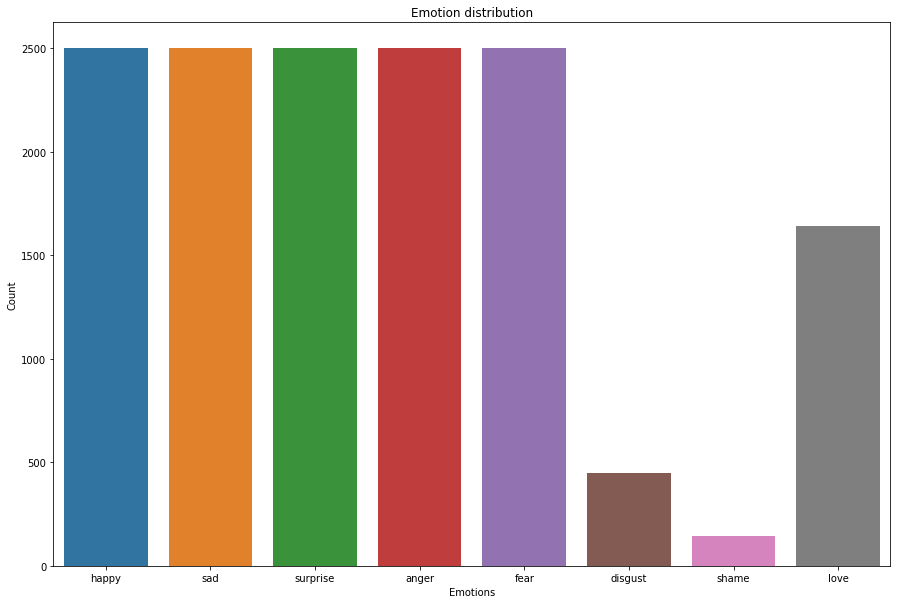

In [22]:
plt.figure(figsize = (15,10))
sns.countplot(x = 'emotion', data=dataset)
plt.title("Emotion distribution")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.show()

In [39]:
i = dataset[((dataset.emotion == 'disgust'))].index

In [40]:
dataset = dataset.drop(i)

In [42]:
i = dataset[((dataset.emotion == 'love'))].index
dataset = dataset.drop(i)

In [43]:
i = dataset[((dataset.emotion == 'shame'))].index
dataset = dataset.drop(i)

In [44]:
dataset['emotion'].value_counts()

happy       2500
sad         2500
surprise    2500
anger       2500
fear        2500
Name: emotion, dtype: int64

---

In [46]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

stemmer = nltk.stem.PorterStemmer()
# getting stemmer

In [47]:
from nltk.corpus import stopwords 
import re
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    
    ## remove numbers
    #sentence = re.sub(r'\d+', '', sentence)    
    
    # remove punctuation and set to lower case
    #for punctuation_mark in string.punctuation:
     #   sentence = sentence.replace(punctuation_mark,'').lower()
    #sentence = tweet_tokenizer.tokenize(sentence)
    sentence = nltk.word_tokenize(sentence) 
    
    
    
    # split sentence into words
    #listofwords = sentence.split(' ')
    listofwords=[word.lower() for word in sentence if word.isalpha()]
    
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [48]:
from nltk.corpus import stopwords

stopwords = stopwords.words('english') #getting stop words

In [49]:
tfidf = TfidfVectorizer(min_df=5,
                        max_df=0.95, # drop words that occur in at least 95% of the documents
                        tokenizer=my_tokenizer) 

In [50]:
data_transformed = tfidf.fit_transform(dataset["text"]) #saving our transformed data and fiting it

In [51]:
my_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=data_transformed.toarray()) #converting to a pandas dataframe with feature names labeled

In [52]:
my_df

,abandon,abil,abit,abl,absolut,abus,accept,access,accid,accident,...,yesterday,yet,york,youd,young,younger,youngster,your,youth,zero
0,0.0,0.0,0.0,0.320444,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12496,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12497,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12498,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
words = tfidf.get_feature_names() #getting the feature names

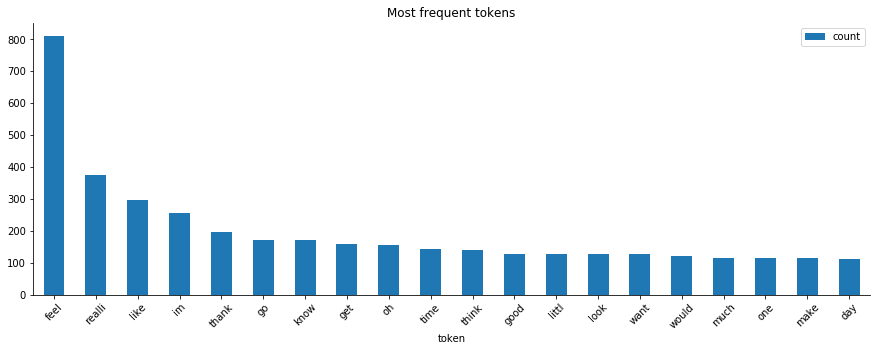

In [54]:
word_weights = my_df.sum(axis=0)


def plot_most_frequent(words, word_weights, top=20):
    words_df = pd.DataFrame({"token": words, 
                             "count": word_weights})
    
    fig, ax = plt.subplots(figsize=(0.75*top, 5))
    words_df.sort_values(by="count", ascending=False).head(top)\
        .set_index("token")\
        .plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most frequent tokens")
    plt.show()
    
    
plot_most_frequent(words, word_weights)

---

In [55]:
X = my_df
y = dataset['emotion']

In [56]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30) #splitting into test and training sets

In [59]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()
robust = robust.fit(X_train)


X_train_robust = robust.transform(X_train)
X_test_robust = robust.transform(X_test)

In [60]:
robust_logit = LogisticRegression(n_jobs=-1)
robust_logit.fit(X_train_robust, y_train)
train_accuracy = robust_logit.score(X_train_robust, y_train)
print(f'Training accuracy: {train_accuracy}')
test_accuracy = robust_logit.score(X_test_robust, y_test)
print(f'Test accuracy: {test_accuracy}')

Training accuracy: 0.8675428571428572
Test accuracy: 0.7674666666666666


In [61]:
filename = 'Model1_NLP.sav'
pickle.dump(robust_logit, open(filename, 'wb'))

In [62]:
tfidf_vect = tfidf.fit(dataset["text"]) 

C:\Users\Isfan\anaconda3\envs\Capstone-NLP\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [63]:
pickle.dump(tfidf_vect, open("tfidf.pickle", "wb"))

---

In [64]:
from dict import dict

def predict_emotion(txt, model):
    sample_transformed = tfidf_vect.transform(txt).toarray()
    prediction = model.predict(sample_transformed)
    prediction_probability = model.predict_proba(sample_transformed)
    print(f"Prediction: {prediction[0]}, Prediction Score: {np.max(prediction_probability)}")
    
    # gets a dictionary of {'class_name': probability}
    prob_per_class_dictionary = dict(zip(model.classes_, prediction_probability[0]))
    return prob_per_class_dictionary

In [65]:
sample_txt = ['This is annoying']
predict_emotion(sample_txt,robust_logit)

Prediction: anger, Prediction Score: 0.9757317571159569


{'anger': 0.9757317571159569,
 'fear': 0.006287032107737191,
 'happy': 0.0059573355309426885,
 'sad': 0.006335667371969829,
 'surprise': 0.005688207873393264}